In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn import linear_model

df=pd.read_excel("Complete-dataset-FINAL.xlsx")

### Note
Dit model is een alternatief voor de lineare regressie model. De algemene bunsiness & data understanding zijn te vinden in de Jupyter notebook van de lineare regressie. In deze notebook zal er gefocust worden op het voorspellingsmodel (ARIMA model).

# Business understanding
We gaan het ARIMA model gebruiken. Hier gaan we kijken of de data stationair is, wat betekent dat een tijdsreeks niet afhankelijk is van tijd. Eerst zullen de parameters voor het ARIMA model worden bepaald. ARIMA(p=?, d=?,q=?)

### ARIMA model
Het doel van een ARIMA model is het nabootsen van een tijdsserie. Dit wordt gedaan door de variaties in de data te modelleren door middel van de volgende drie opties: 

- AR (auto-regressief), voorgaande waardes worden gebruikt om nieuwe waardes te voorspellen.
- I (integrated), niet de originele serie maar een gedifferentieerde tijdsserie wordt gebruikt. Dit om de tijdsserie stationair te maken. 
- MA (moving average), voorafgaande fouten worden gebruikt om nieuwe fouten voorspellen. Dit heeft een smoothing effect, een bewegend gemiddelde. 

Door deze effecten te mengen kun je de meeste tijdsseries nabootsen. In de volgende sectie gaan we de effecten van de AR en MA termen op een tijdsserie bekijken. 



# Data preparation

In [2]:
df=df.dropna()
df.columns = df.columns.str.replace('Total Error', 'Total')
df.columns

Index(['Method name', 'N (no. labs)', 'Mean', 'Bias', 'CV', 'Sample',
       'Reference Value', 'Year', 'Source (CAP/EurA1c)', 'Type (Fresh/frozen)',
       'Manufacturer', 'Total'],
      dtype='object')

In [3]:
df.Year.astype('int32')
df['Year'] =pd.to_datetime(df.Year, format='%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4058 entries, 0 to 4683
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Method name          4058 non-null   object        
 1   N (no. labs)         4058 non-null   object        
 2   Mean                 4058 non-null   float64       
 3   Bias                 4058 non-null   float64       
 4   CV                   4058 non-null   float64       
 5   Sample               4058 non-null   object        
 6   Reference Value      4058 non-null   float64       
 7   Year                 4058 non-null   datetime64[ns]
 8   Source (CAP/EurA1c)  4058 non-null   object        
 9   Type (Fresh/frozen)  4058 non-null   object        
 10  Manufacturer         4058 non-null   object        
 11  Total                4058 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(6)
memory usage: 412.1+ KB


In [4]:
df = df.set_index('Year')
df.head()

,Method name,N (no. labs),Mean,Bias,CV,Sample,Reference Value,Source (CAP/EurA1c),Type (Fresh/frozen),Manufacturer,Total
Year,,,,,,,,,,,
2011-01-01,Vitros 5.1 FS. 4600. 5600,183,6.14,-0.16,2.3,GH2-04,6.3,CAP,Fresh,Vitros,4.348
2011-01-01,Vitros 5.1 FS. 4600. 5600,183,7.59,-0.01,2.5,GH2-05,7.6,CAP,Fresh,Vitros,4.890
2011-01-01,Vitros 5.1 FS. 4600. 5600,183,9.42,0.22,3.0,GH2-06,9.2,CAP,Fresh,Vitros,6.100
2012-01-01,Vitros 5.1 FS. 4600. 5600,210,5.42,-0.18,2.3,GH2-01,5.6,CAP,Fresh,Vitros,4.328
2012-01-01,Vitros 5.1 FS. 4600. 5600,210,9.34,-0.06,2.6,GH2-02,9.4,CAP,Fresh,Vitros,5.036


In [5]:
list_top10 = df['Manufacturer'].value_counts()[:10].index.tolist()
top10_manufacturers = df.loc[df['Manufacturer'].isin(list_top10)]
top10_manufacturers['Manufacturer'].value_counts()
top10_manufacturers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3737 entries, 2011-01-01 to 2021-01-01
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Method name          3737 non-null   object 
 1   N (no. labs)         3737 non-null   object 
 2   Mean                 3737 non-null   float64
 3   Bias                 3737 non-null   float64
 4   CV                   3737 non-null   float64
 5   Sample               3737 non-null   object 
 6   Reference Value      3737 non-null   float64
 7   Source (CAP/EurA1c)  3737 non-null   object 
 8   Type (Fresh/frozen)  3737 non-null   object 
 9   Manufacturer         3737 non-null   object 
 10  Total                3737 non-null   float64
dtypes: float64(5), object(6)
memory usage: 350.3+ KB


In [6]:
# manufacturers = df.groupby("Manufacturer")
manufacturers = top10_manufacturers.groupby("Manufacturer")
manufacturers.size().nlargest(20)

Manufacturer
Siemens              918
Bio-Rad              667
Roche Diagnostics    605
Beckman Coulter      349
Tosoh                284
Abbott               278
Sebia                201
Trinity Biotech      185
Vitros               139
Alere                111
dtype: int64

In [7]:
top10_manufacturers = top10_manufacturers.dropna()
# top10_manufacturers=top10_manufacturers[['Manufacturer', 'Total', 'Year']]
top10_manufacturers=top10_manufacturers[['Manufacturer', 'Total']]
top10_manufacturers.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3737 entries, 2011-01-01 to 2021-01-01
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Manufacturer  3737 non-null   object 
 1   Total         3737 non-null   float64
dtypes: float64(1), object(1)
memory usage: 87.6+ KB


Abbott


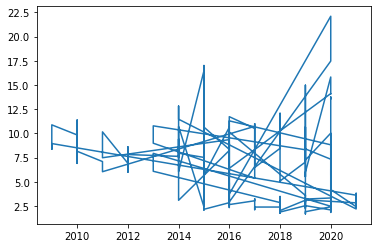

Alere


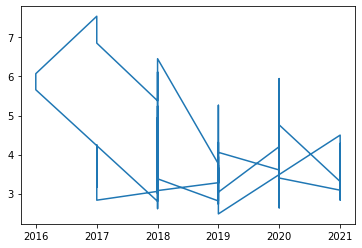

Beckman Coulter


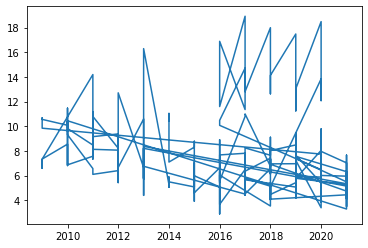

Bio-Rad


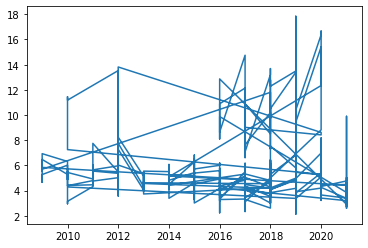

Roche Diagnostics


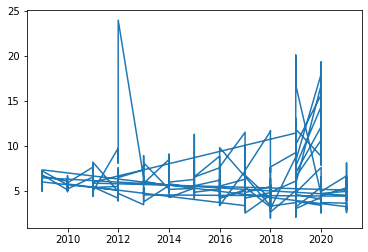

Sebia


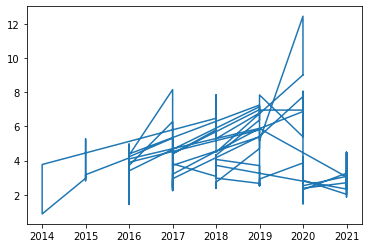

Siemens


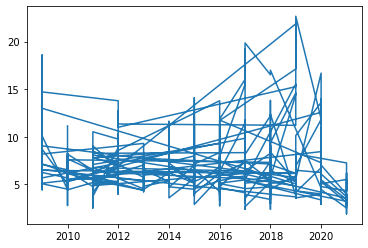

Tosoh


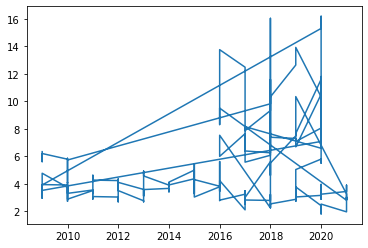

Trinity Biotech


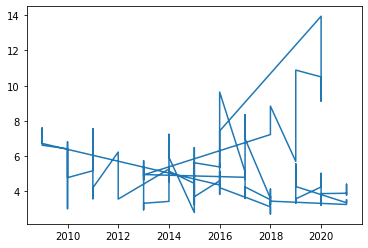

Vitros


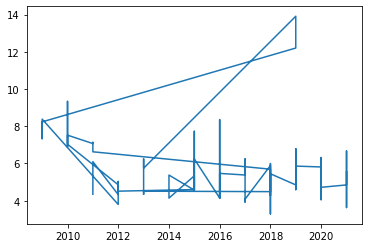

In [8]:
for name, data in manufacturers:
    print(name)
    plt.plot(data.index, data['Total'])
    plt.show()

# Note
Hier is te zien dat er niet een duidelijke lijn wordt weergegeven van door de jaren heen. Dit is een indicatie dat het ARIMA model mogelijk niet geschikt zal zijn.

# Modeling : parameters ARIMA

In [9]:
top10_manufacturers= top10_manufacturers.dropna()
manufacturers = top10_manufacturers.groupby("Manufacturer")

Abbott


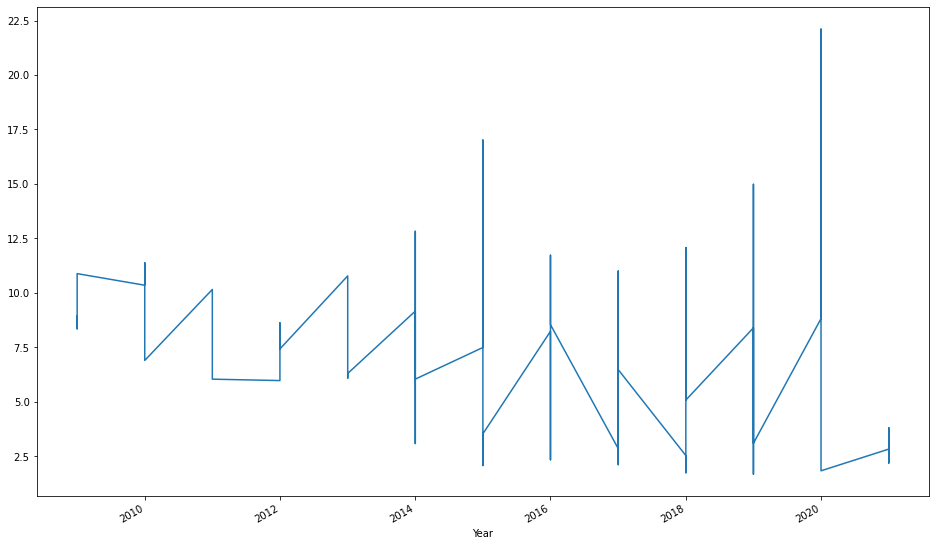



ADF Statistic: -1.9898120102862142
n_lags: 0.2910579663482772
p-value: 0.2910579663482772
Critial Values:
   1%, -3.4554613060274972
Critial Values:
   5%, -2.8725931472675046
Critial Values:
   10%, -2.5726600403359887


Alere


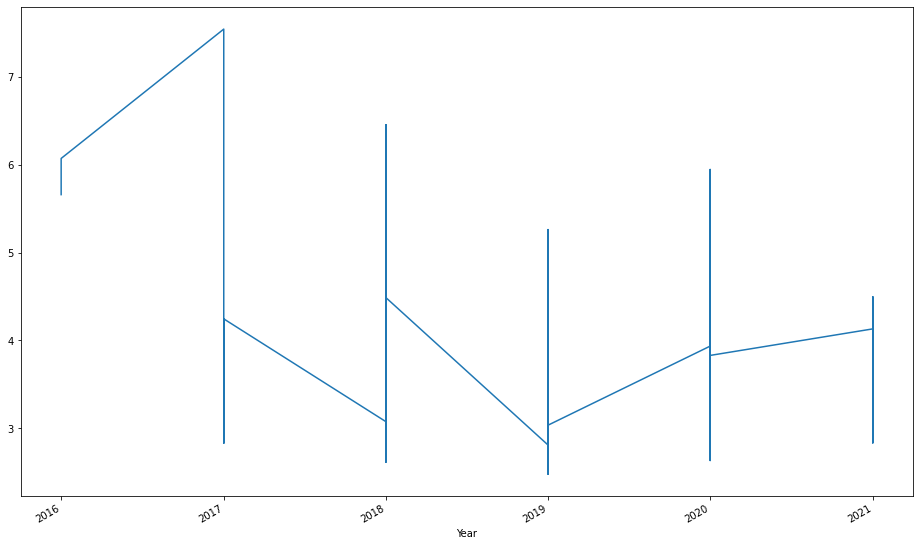



ADF Statistic: -4.340042847938979
n_lags: 0.0003783913537194649
p-value: 0.0003783913537194649
Critial Values:
   1%, -3.49181775886872
Critial Values:
   5%, -2.8884437992971588
Critial Values:
   10%, -2.5811201893779985


Beckman Coulter


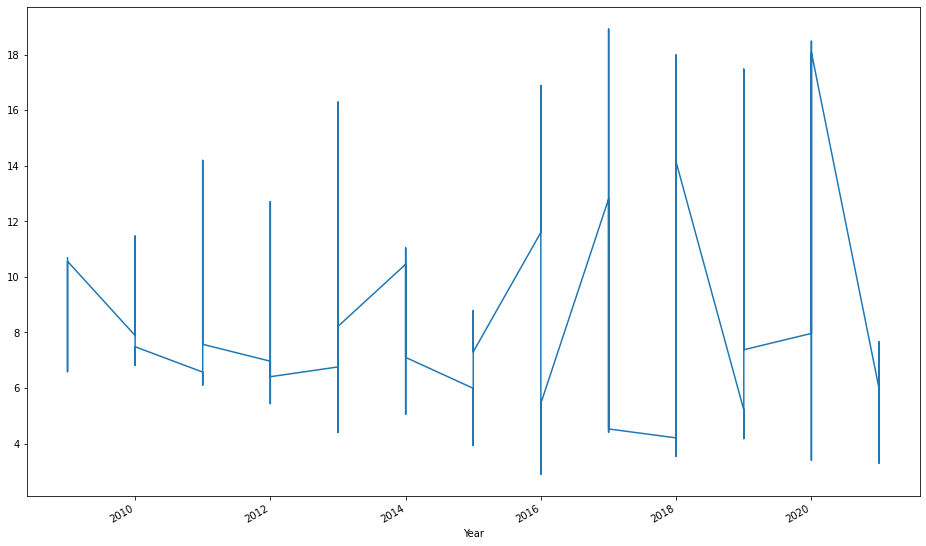



ADF Statistic: -3.2663735133490923
n_lags: 0.016450142108014498
p-value: 0.016450142108014498
Critial Values:
   1%, -3.4495033946549123
Critial Values:
   5%, -2.8699787979596136
Critial Values:
   10%, -2.5712658305164955


Bio-Rad


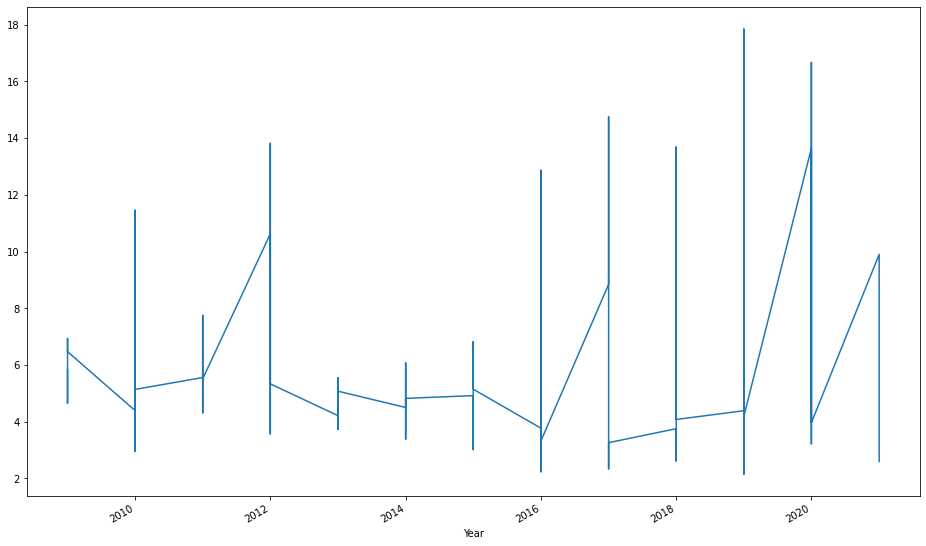



ADF Statistic: -5.086968935872918
n_lags: 1.4889943958397804e-05
p-value: 1.4889943958397804e-05
Critial Values:
   1%, -3.4405132737812596
Critial Values:
   5%, -2.8660244429195725
Critial Values:
   10%, -2.5691581552588447


Roche Diagnostics


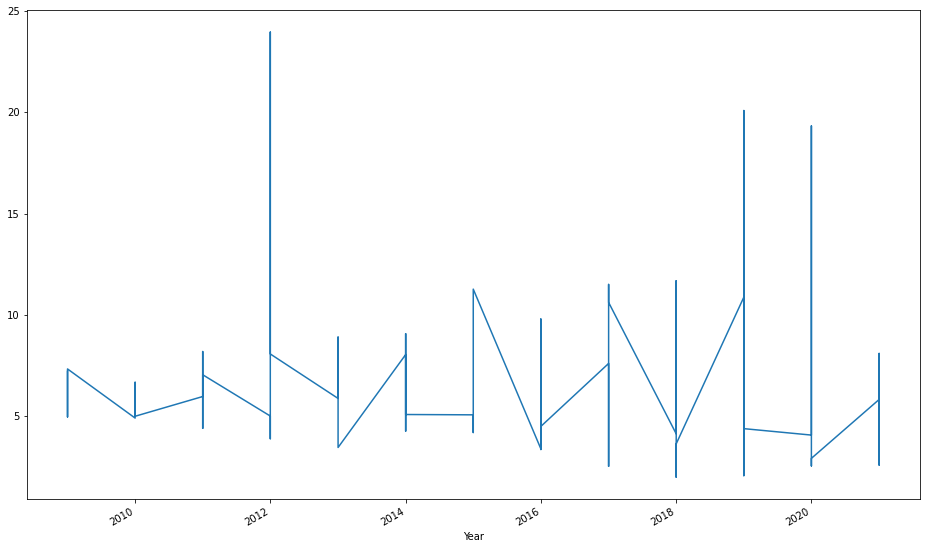



ADF Statistic: -2.4792452298597816
n_lags: 0.12060619421690999
p-value: 0.12060619421690999
Critial Values:
   1%, -3.4414256033746606
Critial Values:
   5%, -2.8664262627821473
Critial Values:
   10%, -2.569372254520843


Sebia


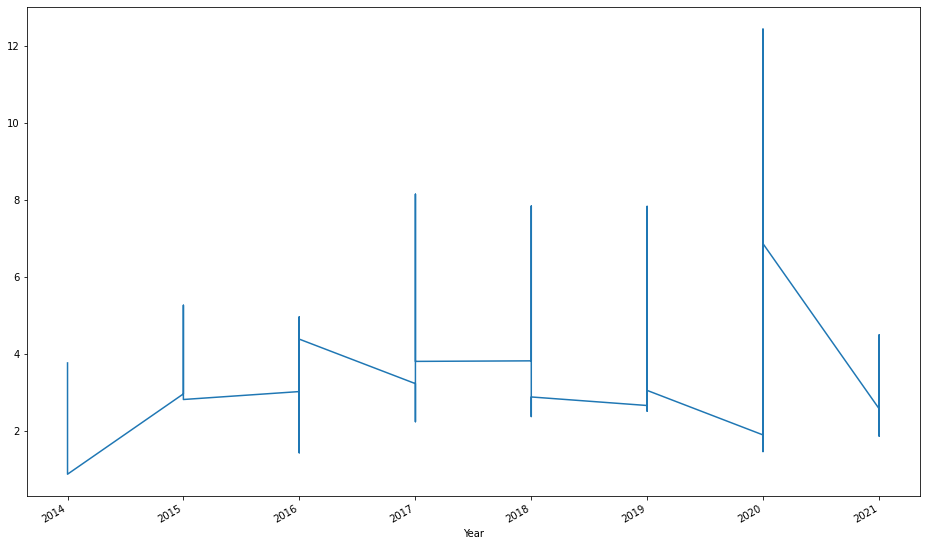



ADF Statistic: -4.4049548638934946
n_lags: 0.00029089628406277484
p-value: 0.00029089628406277484
Critial Values:
   1%, -3.4636447617687436
Critial Values:
   5%, -2.8761761179270766
Critial Values:
   10%, -2.57457158581854


Siemens


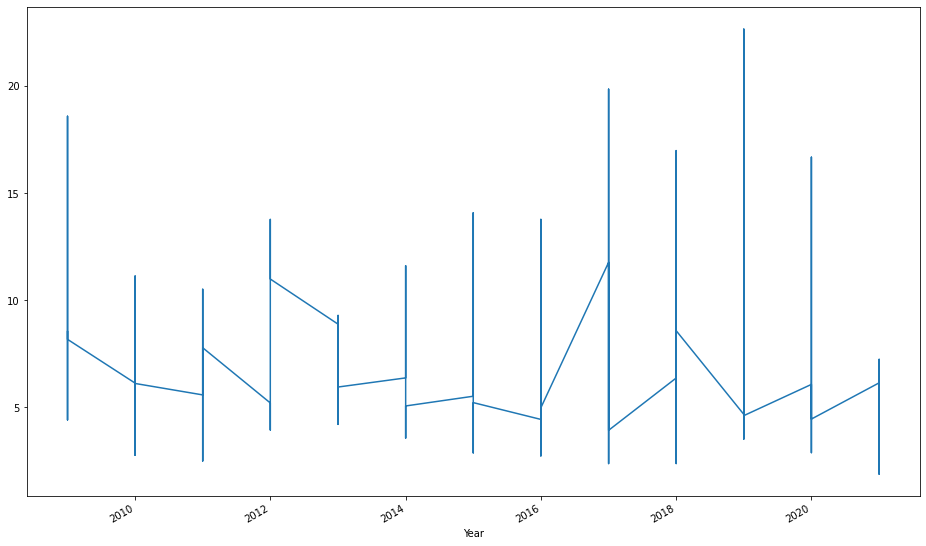



ADF Statistic: -8.420257639680607
n_lags: 1.992421825485748e-13
p-value: 1.992421825485748e-13
Critial Values:
   1%, -3.437524792681557
Critial Values:
   5%, -2.8647073745235074
Critial Values:
   10%, -2.568456513461879


Tosoh


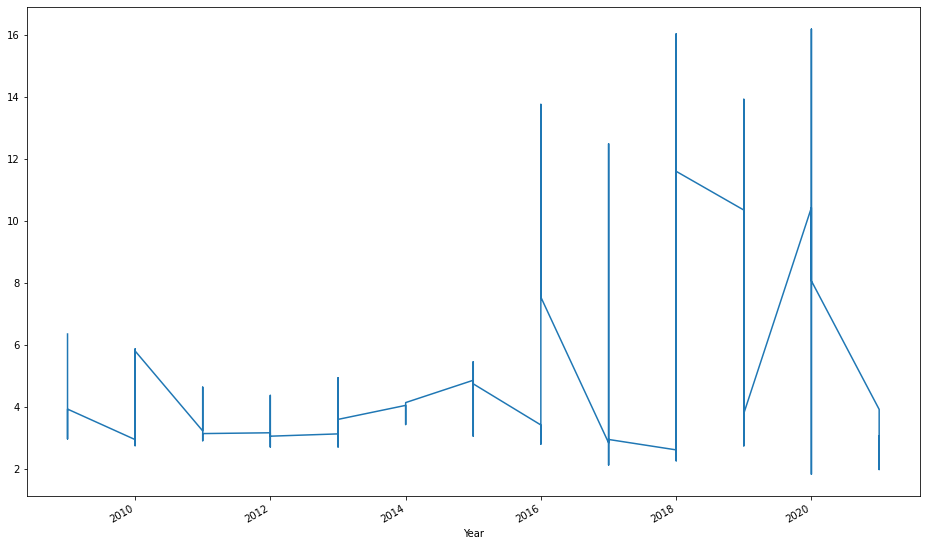



ADF Statistic: -3.7610339942094977
n_lags: 0.003332117543435071
p-value: 0.003332117543435071
Critial Values:
   1%, -3.453922368485787
Critial Values:
   5%, -2.871918329081633
Critial Values:
   10%, -2.5723001147959184


Trinity Biotech


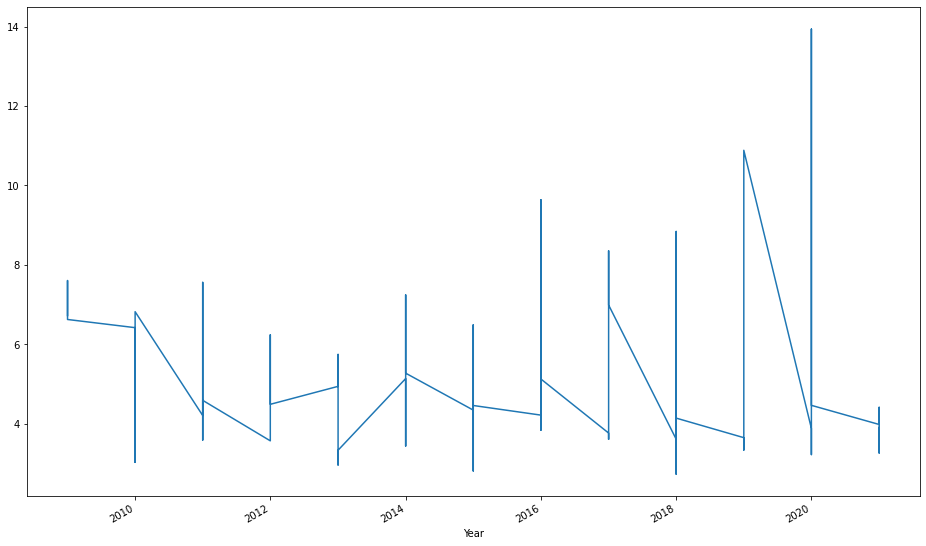



ADF Statistic: -3.072718389283137
n_lags: 0.028639140207967508
p-value: 0.028639140207967508
Critial Values:
   1%, -3.4682803641749267
Critial Values:
   5%, -2.8782017240816327
Critial Values:
   10%, -2.5756525795918366


Vitros


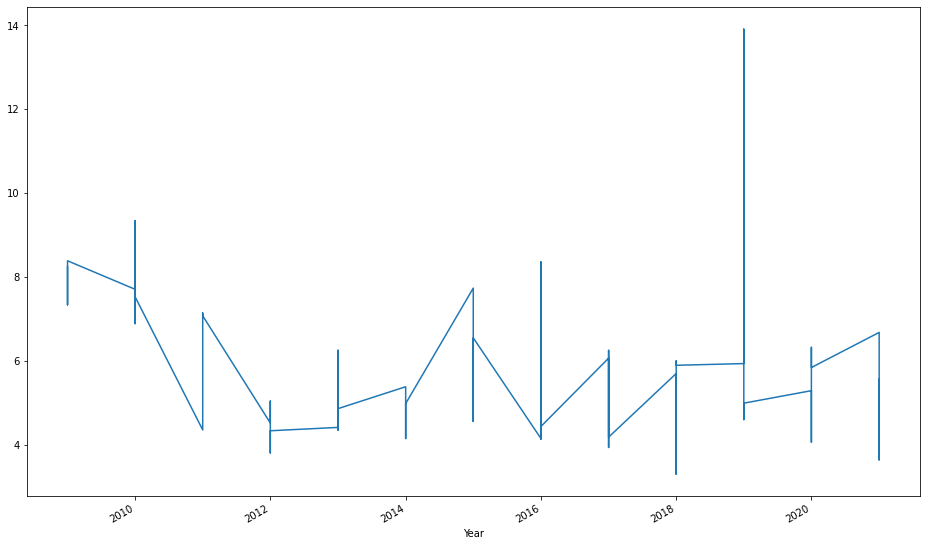



ADF Statistic: -4.937546891953932
n_lags: 2.945705182878482e-05
p-value: 2.945705182878482e-05
Critial Values:
   1%, -3.479007355368944
Critial Values:
   5%, -2.8828782366015093
Critial Values:
   10%, -2.5781488587564603


Meetmethoden met een p-waarden van boven de 0.05:


['Abbott', 'Roche Diagnostics']

In [10]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series data can said to have stationarity
from statsmodels.tsa.stattools import adfuller
List_meetmethoden = []


#AIC input is to compute the optimal number iteratively.
for name, data in manufacturers: 
    data= data.dropna()
    print(name) 
    df_stationarityTest = adfuller(data['Total'], autolag='AIC')    
    
    data['Total'].plot(figsize=(16,10))
    plt.show() 
    print("\n")
    print(f'ADF Statistic: {df_stationarityTest[0]}')
    print(f'n_lags: {df_stationarityTest[1]}')
    print(f'p-value: {df_stationarityTest[1]}')
    for key, value in df_stationarityTest[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')    

    
    if df_stationarityTest[1] > 0.05:
        List_meetmethoden.append(name)
    print("\n")

print("Meetmethoden met een p-waarden van boven de 0.05:")
List_meetmethoden

### Analyse van p-values
Een p-value van 0.05 of er onder ligt, betekent dat de data stationair is. De resultaten laten zien dat bij sommige de meetmethoden de data niet stationair is. Dit betekent dat bij deze meetmethoden nullhypothese (voorspelt geen effect of relatie) mogelijk van toepassing is.
Om deze meetmethoden stationair te maken, wordt het gedifferentieerd. 

#### Differentiatie van meetmethoden met p-value > 0.05


Abbott


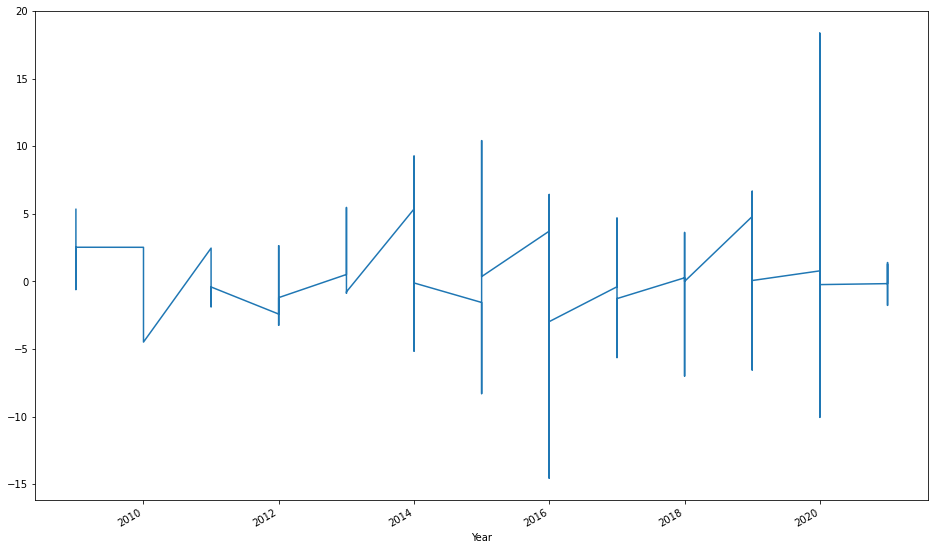


ADF Statistic: -5.469566816634768
n_lags: 2.415706937875997e-06
p-value: 2.415706937875997e-06
Critial Values:
   1%, -3.4554613060274972
Critial Values:
   5%, -2.8725931472675046
Critial Values:
   10%, -2.5726600403359887

Roche Diagnostics


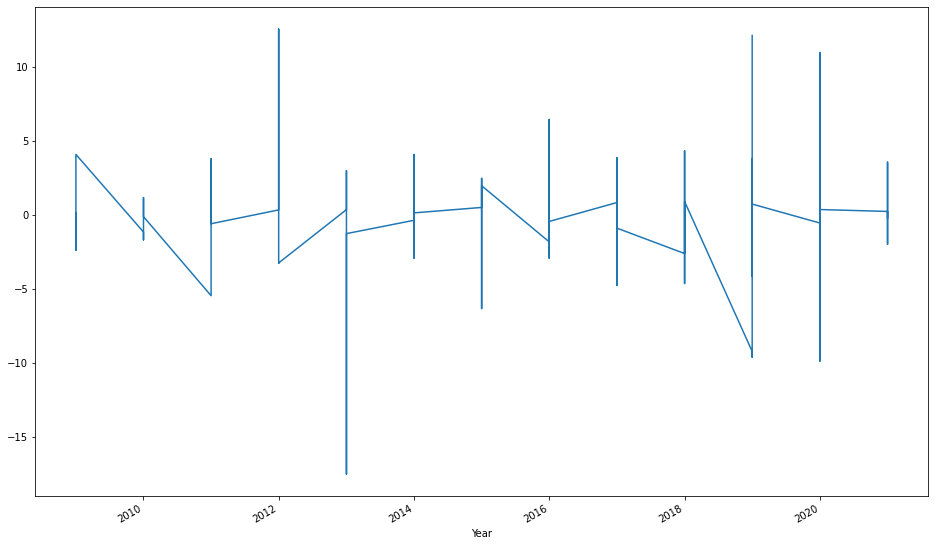


ADF Statistic: -11.397196142263795
n_lags: 7.805836700752563e-21
p-value: 7.805836700752563e-21
Critial Values:
   1%, -3.4414256033746606
Critial Values:
   5%, -2.8664262627821473
Critial Values:
   10%, -2.569372254520843


In [11]:
#Één keer diffrentiëren
for name, data in manufacturers:
    if name in List_meetmethoden:
        print("\n" + name) 
        df_stationarityTest = adfuller(data['Total'].diff().dropna(), autolag='AIC')   
        data['Total'].diff().plot(figsize=(16,10))
        plt.show() 
        
        print("")
        print(f'ADF Statistic: {df_stationarityTest[0]}')
        print(f'n_lags: {df_stationarityTest[1]}')
        print(f'p-value: {df_stationarityTest[1]}')
        for key, value in df_stationarityTest[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')    

        

In [12]:
#2x diff = I (ARIMA)
for name, data in manufacturers:
    if name in List_meetmethoden:
        print("\n")
        print(name) 
        # data['Total'].diff().diff().plot(figsize=(16,10))
        # plt.show()
        data_diff = data['Total'].diff().diff().dropna()
        
        df_stationarityTest = adfuller(data_diff, autolag='AIC')    

        print(f'ADF Statistic: {df_stationarityTest[0]}')
        print(f'n_lags: {df_stationarityTest[1]}')
        print(f'p-value: {df_stationarityTest[1]}')
        for key, value in df_stationarityTest[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')    




Abbott
ADF Statistic: -8.002101000544437
n_lags: 2.319181934104735e-12
p-value: 2.319181934104735e-12
Critial Values:
   1%, -3.4556556713934934
Critial Values:
   5%, -2.872678352489859
Critial Values:
   10%, -2.57270548832225


Roche Diagnostics
ADF Statistic: -12.627807881926982
n_lags: 1.527989791714807e-23
p-value: 1.527989791714807e-23
Critial Values:
   1%, -3.4415584920942424
Critial Values:
   5%, -2.866484781324317
Critial Values:
   10%, -2.569403436033035



# Conclusie p-waarden
Hier is te zien dat bij 2 keer differentiëren dat de p-waarden juist groter worden. Voor het ARIMA model wordt de kleinste p-waarde gebruikt. Daarom nemen we 0 als parameter bij alle meetmethoden. Dus ARIMA(p=?,d=0,q=?)

# Data preparation ACF & PACF

### ACF plot

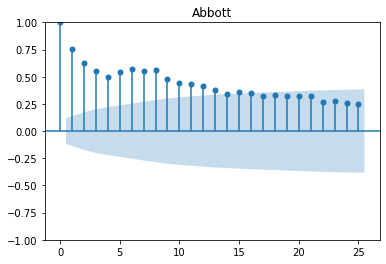

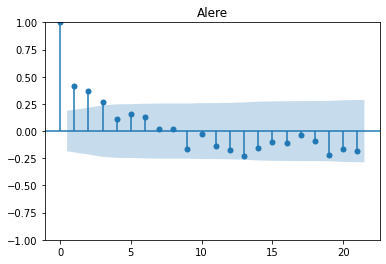

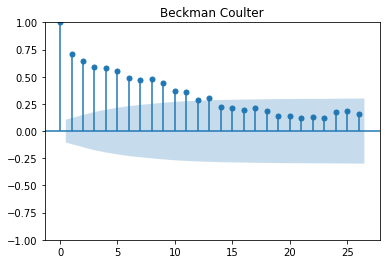

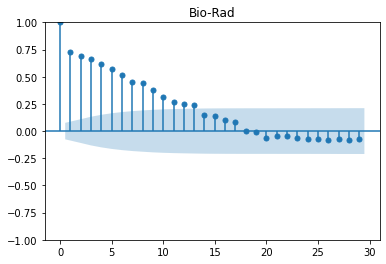

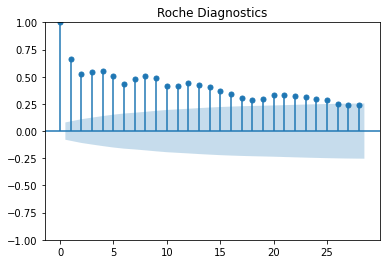

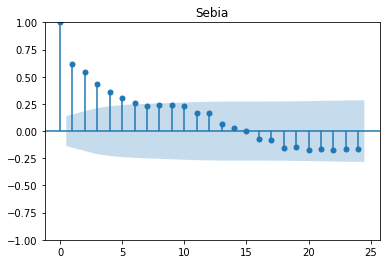

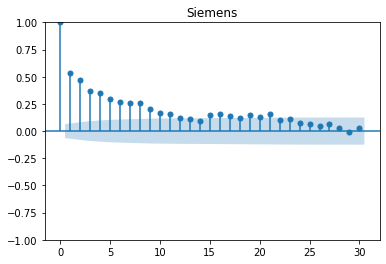

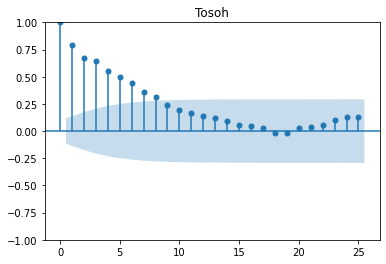

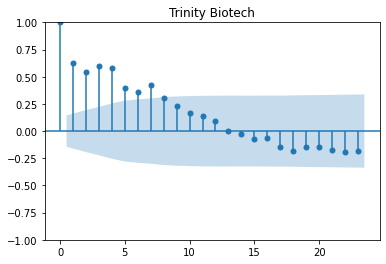

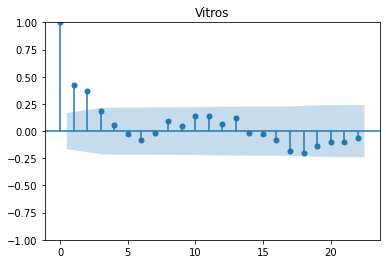

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
for name, data in manufacturers: 
    acf =plot_acf(data['Total'], title=name, alpha=.05)
    

### Analyse van ACF plot
In dit autocorrelatieplot liggen bijna alle waardes niet binnen het lichtblauwe onzekerheidsgebied (deze variantie in autocorrelatie kan mogelijk worden verklaard door ruis). Dit betekent dat we juist wel MA-parameter moeten in te stellen (datapunten buiten het onzekerheidgebied).
Per methode is er een andere MA waarden. 

In [14]:
Lijst_MA = [13,2,11,13,26,5,15,8,7,2]

C:\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The defa

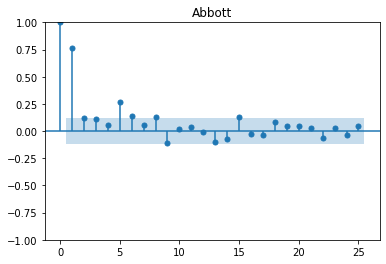

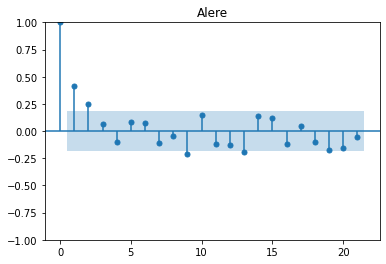

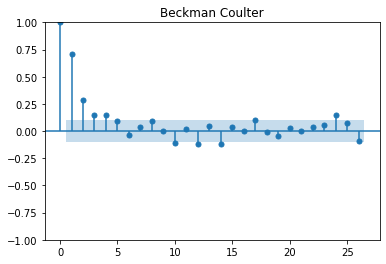

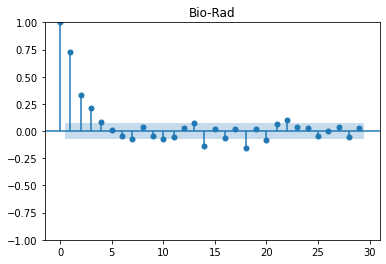

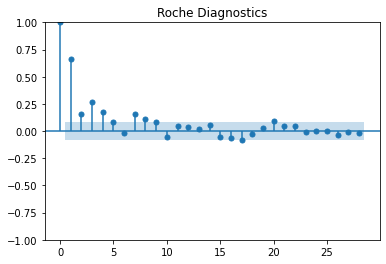

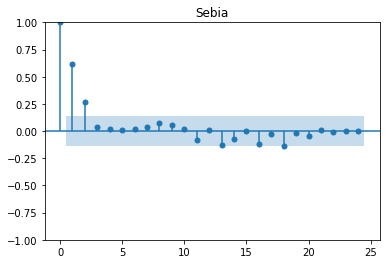

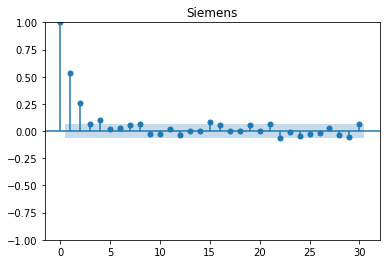

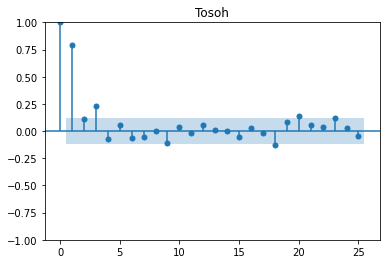

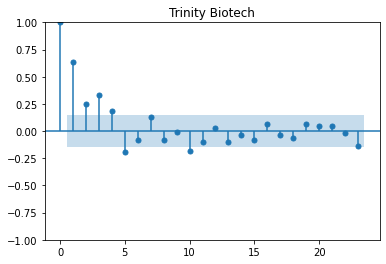

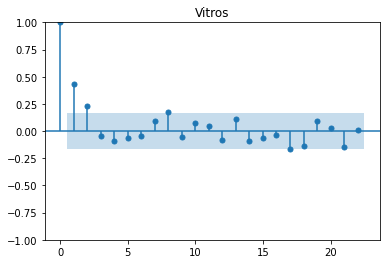

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

for name, data in manufacturers: 
    pacf = plot_pacf(data['Total'], title=name)

### Analyse van pacf plot
De partiële autocorrelatie geeft weer hoe sterk het verband is tussen de waarde van een lag en de waarde van voorgaande lags. Als er tussen de lags nog significante correlatie bestaat is dit een aanwijzing dat er auto-correlatie optreed en dat het instellen van de AR parameter een goed idee is.

Bij alle grafieken is te zien dat de eerste lag het meest significant is. Daarom nemen we p met de waarde 1. Dus ARIMA(p=1,d=0,q=lijst_MA)

# ARIMA modeling

In [16]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
# top10_manufacturers.set_index('Year')

In [17]:
counter= 0
from sklearn.model_selection import train_test_split

import datetime
for name, data in manufacturers:
    print(name)
    data.index = pd.DatetimeIndex(data.index).to_period('M')

    model = sm.tsa.arima.ARIMA(data['Total'].diff().dropna(), order=(0,2,Lijst_MA[counter]))
    model_fit = model.fit()
    print(model_fit.summary())
    counter = counter +1
    
   
#P>|z| significant? onder 0.01

Abbott


C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to conve

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  277
Model:                ARIMA(0, 2, 13)   Log Likelihood                -649.775
Date:                Tue, 24 May 2022   AIC                           1327.551
Time:                        09:40:13   BIC                           1378.186
Sample:                             0   HQIC                          1347.872
                                - 277                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.2791      1.114     -2.046      0.041      -4.463      -0.096
ma.L2          1.3800      7.369      0.187      0.851     -13.063      15.823
ma.L3          0.0963      9.401      0.010      0.9

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  110
Model:                 ARIMA(0, 2, 2)   Log Likelihood                -163.983
Date:                Tue, 24 May 2022   AIC                            333.966
Time:                        09:40:14   BIC                            342.013
Sample:                             0   HQIC                           337.229
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9952     19.578     -0.102      0.919     -40.368      36.378
ma.L2          0.9998     19.623      0.051      0.959     -37.460      39.459
sigma2         1.0780     21.133      0.051      0.9

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  348
Model:                ARIMA(0, 2, 11)   Log Likelihood                -712.584
Date:                Tue, 24 May 2022   AIC                           1449.167
Time:                        09:40:20   BIC                           1495.325
Sample:                             0   HQIC                          1467.547
                                - 348                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.5318      0.140    -18.141      0.000      -2.805      -2.258
ma.L2          2.0352      0.227      8.972      0.000       1.591       2.480
ma.L3         -0.5395      0.136     -3.973      0.0

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  666
Model:                ARIMA(0, 2, 13)   Log Likelihood               -1154.693
Date:                Tue, 24 May 2022   AIC                           2337.385
Time:                        09:40:33   BIC                           2400.361
Sample:                             0   HQIC                          2361.788
                                - 666                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.5501      0.027    -95.180      0.000      -2.603      -2.498
ma.L2          2.0984      0.079     26.586      0.000       1.944       2.253
ma.L3         -0.4820      0.105     -4.575      0.0

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to conve

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  604
Model:                ARIMA(0, 2, 26)   Log Likelihood               -1211.341
Date:                Tue, 24 May 2022   AIC                           2476.683
Time:                        09:41:22   BIC                           2595.490
Sample:                             0   HQIC                          2522.925
                                - 604                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.5730      0.229    -11.225      0.000      -3.022      -2.124
ma.L2          2.0388      0.797      2.558      0.011       0.477       3.601
ma.L3         -0.3667      1.187     -0.309      0.7

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  200
Model:                 ARIMA(0, 2, 5)   Log Likelihood                -349.759
Date:                Tue, 24 May 2022   AIC                            711.518
Time:                        09:41:24   BIC                            731.248
Sample:                             0   HQIC                           719.504
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.5276      1.018     -2.483      0.013      -4.523      -0.533
ma.L2          2.0599      1.558      1.322      0.186      -0.994       5.114
ma.L3         -0.6517      0.587     -1.111      0.2

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  917
Model:                ARIMA(0, 2, 15)   Log Likelihood               -1919.618
Date:                Tue, 24 May 2022   AIC                           3871.236
Time:                        09:41:46   BIC                           3948.339
Sample:                             0   HQIC                          3900.667
                                - 917                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.6083      0.020   -127.878      0.000      -2.648      -2.568
ma.L2          2.2048      0.056     39.670      0.000       2.096       2.314
ma.L3         -0.6885      0.078     -8.832      0.0

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  283
Model:                 ARIMA(0, 2, 8)   Log Likelihood                -533.418
Date:                Tue, 24 May 2022   AIC                           1084.836
Time:                        09:41:49   BIC                           1117.581
Sample:                             0   HQIC                          1097.969
                                - 283                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.2230      0.226     -9.821      0.000      -2.667      -1.779
ma.L2          1.1948      0.304      3.928      0.000       0.599       1.791
ma.L3          0.4159      0.137      3.038      0.0

C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to conve

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  184
Model:                 ARIMA(0, 2, 7)   Log Likelihood                -291.153
Date:                Tue, 24 May 2022   AIC                            598.306
Time:                        09:41:52   BIC                            623.938
Sample:                             0   HQIC                           608.697
                                - 184                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -2.5405      2.559     -0.993      0.321      -7.555       2.474
ma.L2          2.0567      3.937      0.522      0.601      -5.660       9.773
ma.L3         -0.4009      1.326     -0.302      0.7

In [18]:
# # Build Model
# from sklearn.model_selection import train_test_split
# counter= 0

# for name, data in manufacturers:
#     tempdf = data[['Year', 'Total']]
#     tempdf['Total']= data['Total'].diff().dropna()
    
#     X = tempdf.iloc[:, :-1].values
#     Y = tempdf.iloc[:, 1].values

#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
 
#     model = ARIMA(X_train, order=(0, 2 , Lijst_MA[counter]))  
#     fitted = model.fit()  

#     # Plot
#     # plt.figure(figsize=(12,5))
#     plt.plot(X_train, label='training')
#     plt.plot(X_test, label='actual')
#     plt.show()
    

Abbott


C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


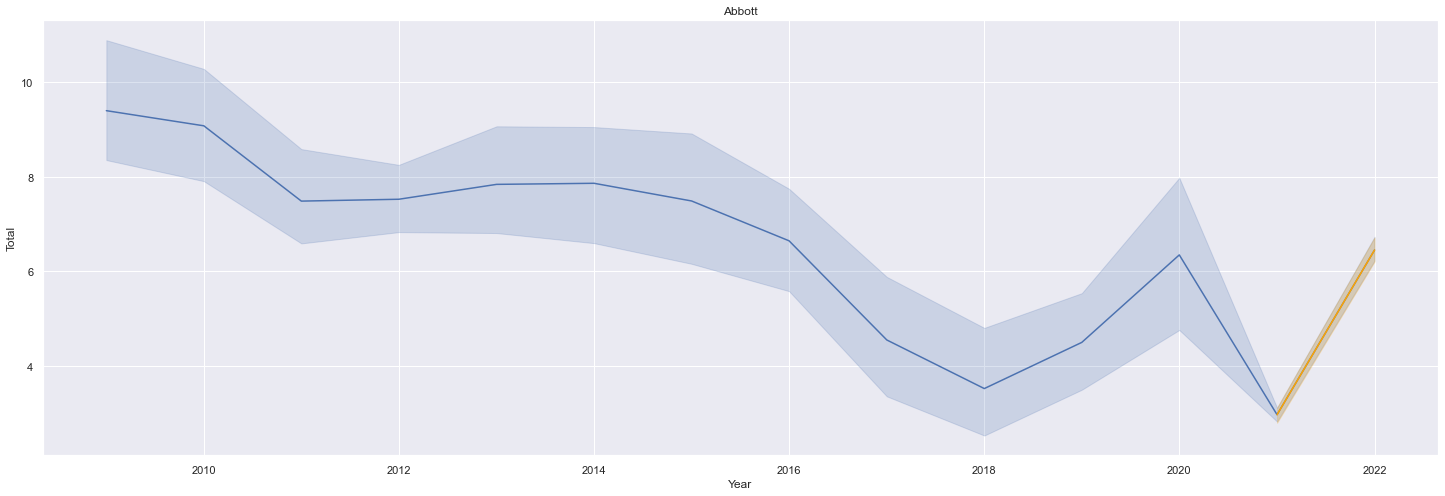

Alere


C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


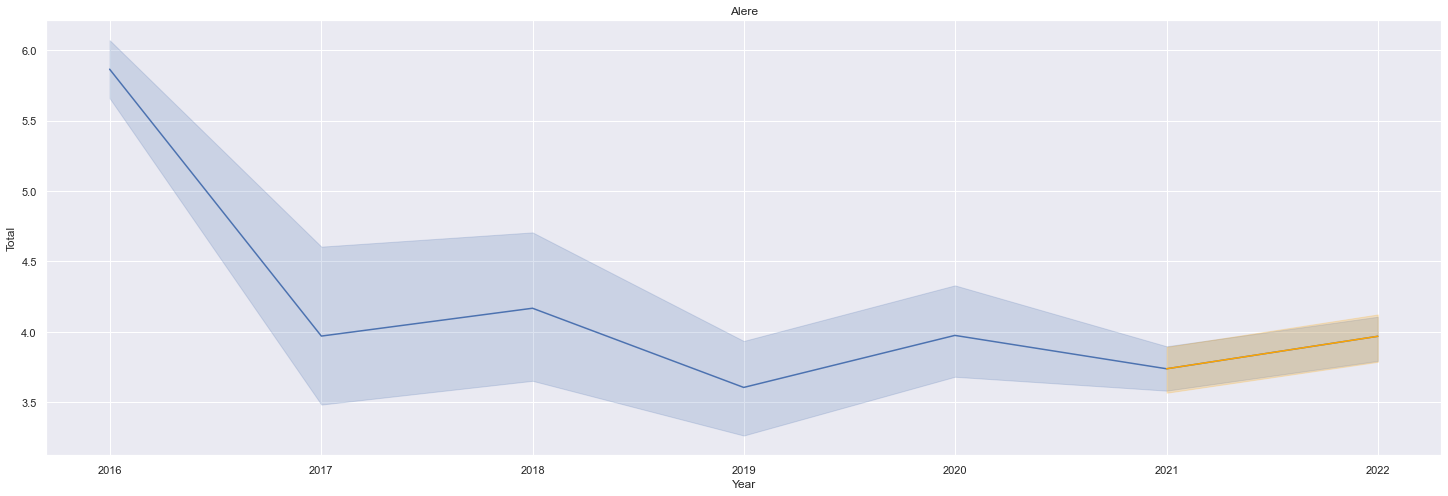

Beckman Coulter


C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


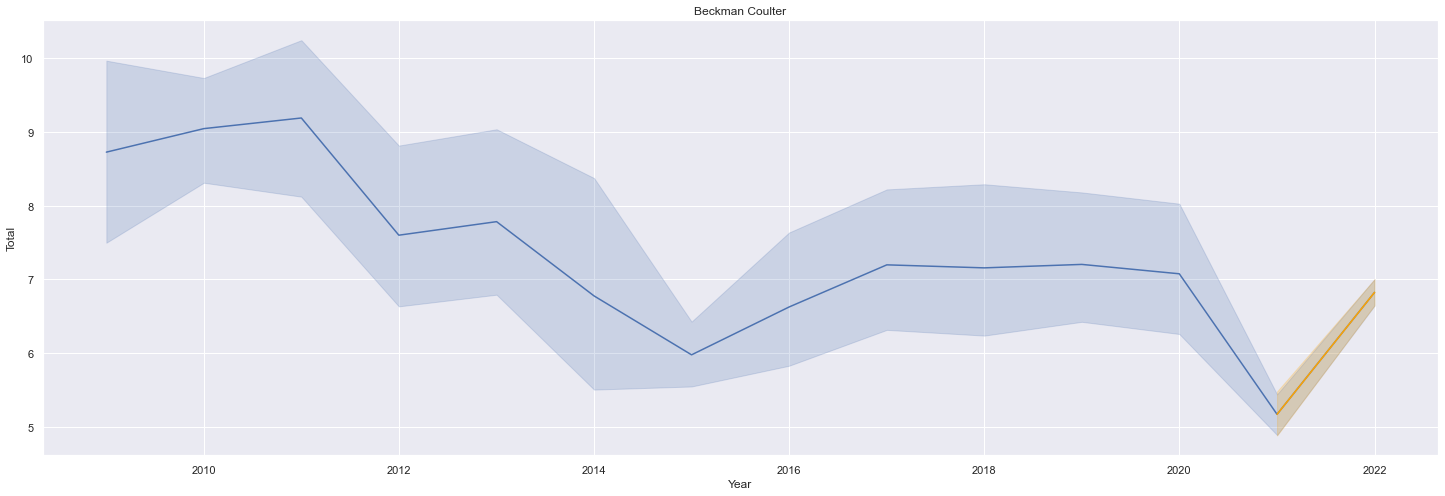

Bio-Rad


C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


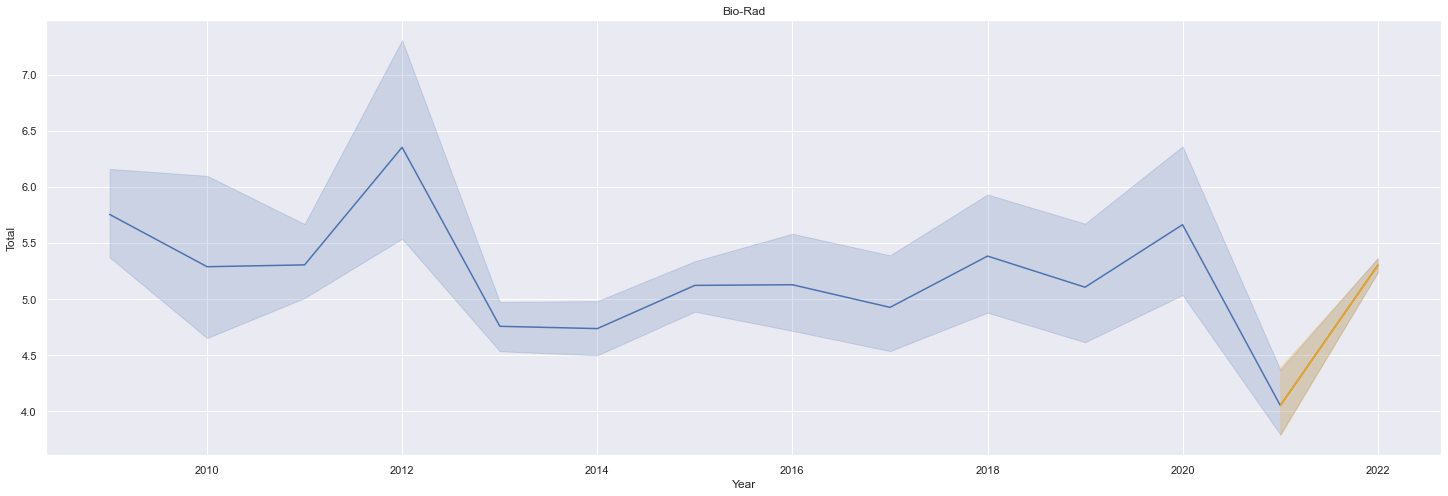

Roche Diagnostics


C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


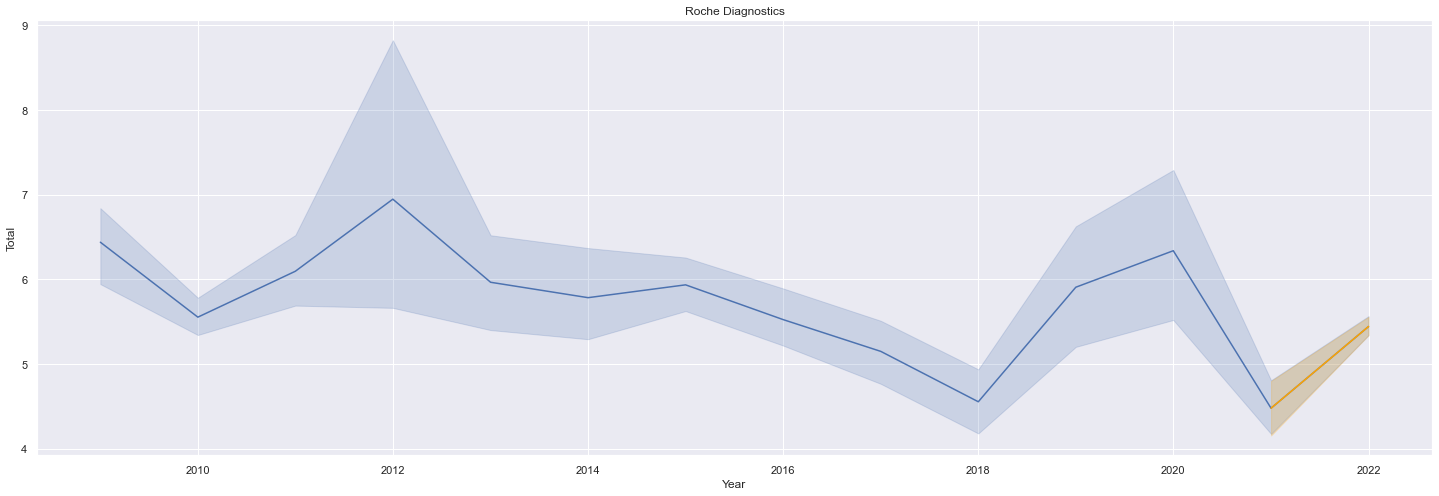

Sebia


C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


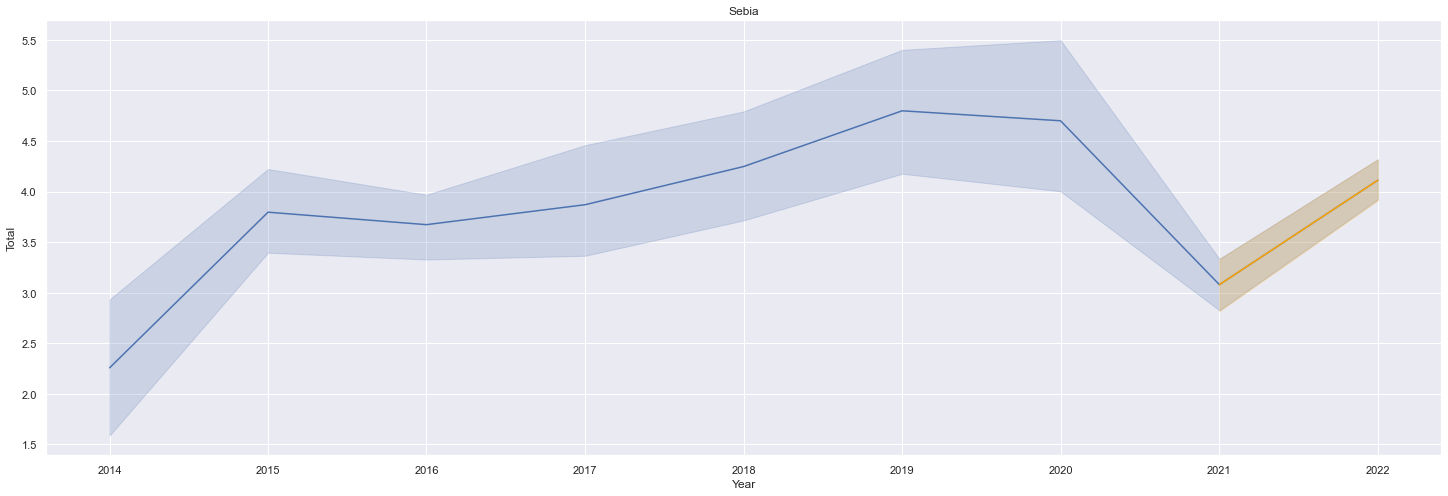

Siemens


C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


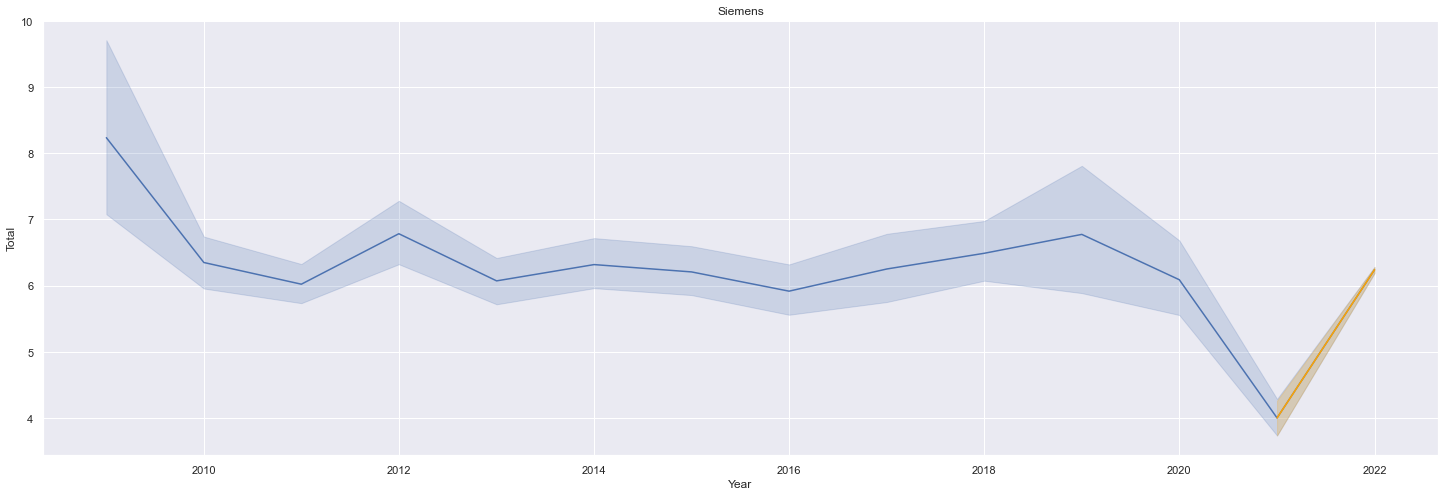

Tosoh


C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


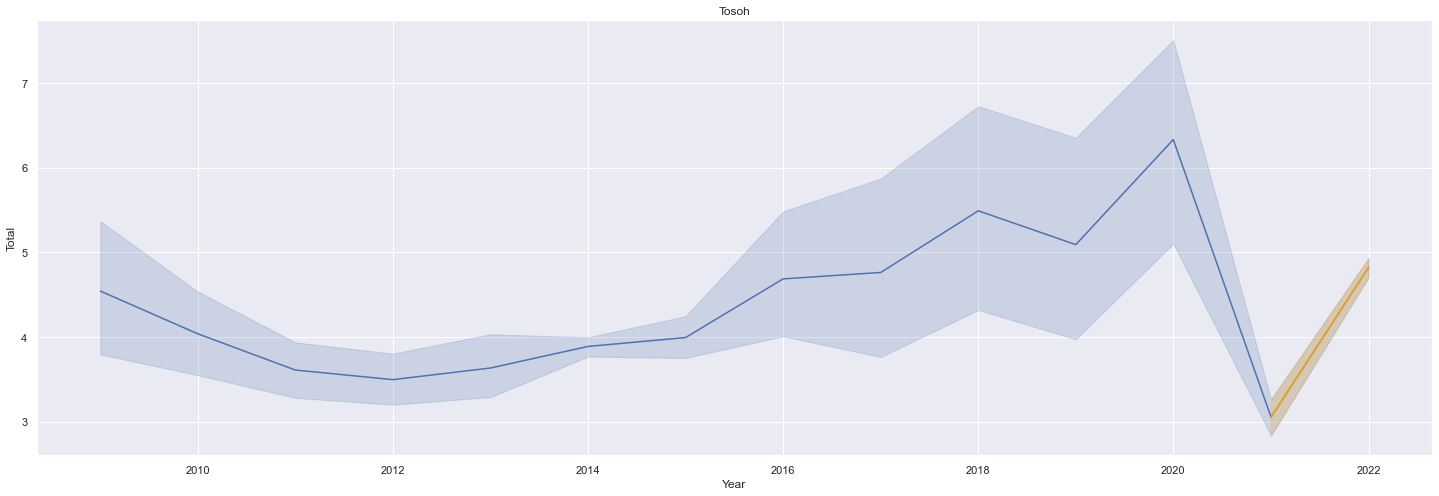

Trinity Biotech


C:\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


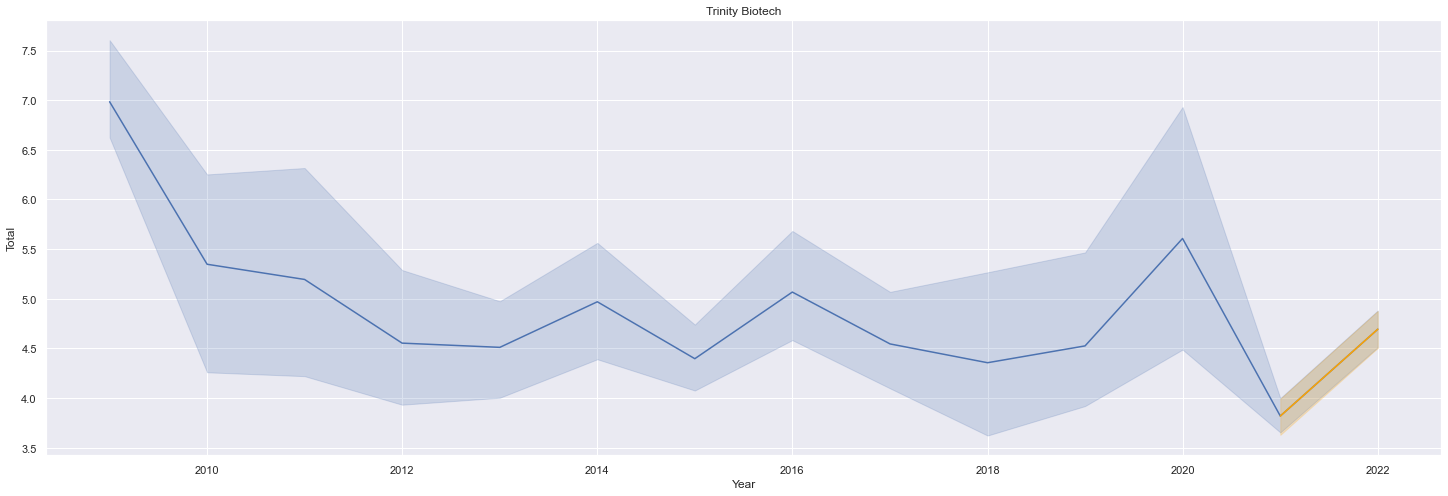

Vitros


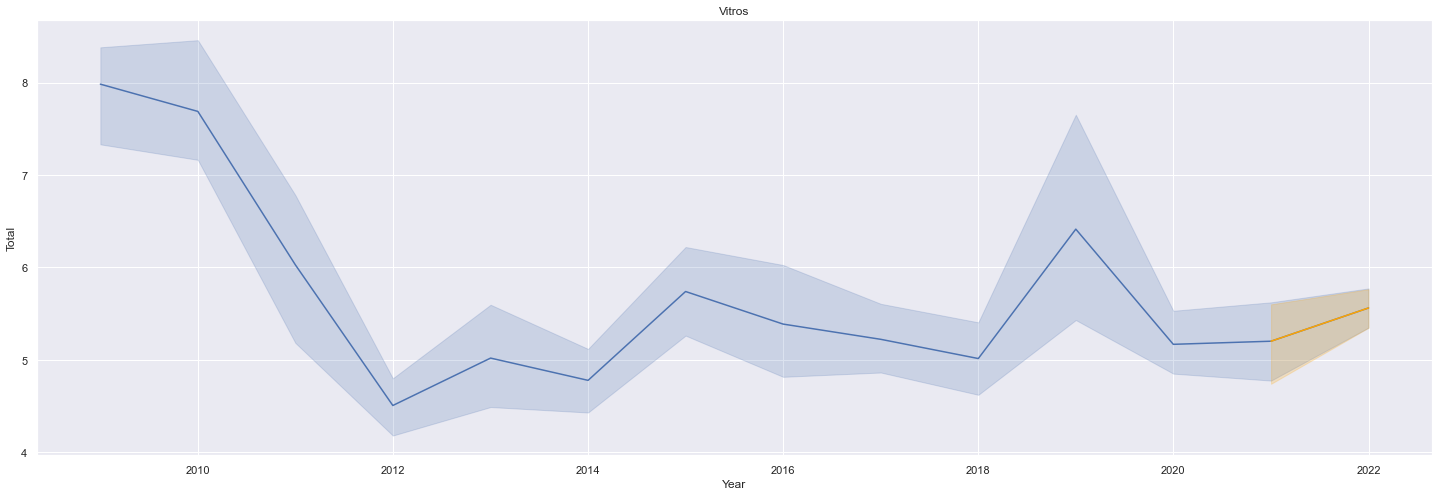

In [31]:
counter= 0
from sklearn.model_selection import train_test_split

import datetime
for name, data in manufacturers:
    tempdf = data[['Total']].dropna()
    X = tempdf.iloc[:, :1].values
    Y = tempdf.index.values
    # print(tempdf.iloc[:, :1].values)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)

    print(name)
    # data.index = pd.DatetimeIndex(data.index).to_period('M')

    model = sm.tsa.arima.ARIMA(X_train, order=(0,2,Lijst_MA[counter]))
    model_fit = model.fit()
    # print(model_fit.summary())
    counter = counter +1

    y_pred = model_fit.predict(disp=0, exog=None, dynamic=False)
    # print(y_pred)
    preddf = pd.DataFrame(y_pred, columns=['Total'])
    preddf['Year'] = pd.to_datetime('2022-01-01')
    
    
    # Add tempdf and preddf together and reset index
    tempdf = pd.concat([tempdf.reset_index(), preddf], axis=0, ignore_index=True)
    
    # print(tempdf)

    # Set the correct type 
    # tempdf = tempdf.astype({'Year': 'int32'})
    
    # pred = model_fit.predict(start = max(tempdf.index), end= max(tempdf.index)+5)
    # plt.show()
    sns.set(rc = {'figure.figsize':(25,8)})
    l = sns.lineplot(x='Year', y='Total', data=tempdf)
    l.set_title(name)
    sns.lineplot(x='Year', y='Total', data=tempdf[(tempdf['Year'] >= pd.to_datetime('2021-01-01')) & (tempdf['Year'] <= pd.to_datetime('2022-01-01'))], color='orange')
    plt.show()